# NAME - SRIKAR PADALIYA
# ID - 202101095


### In this part we are going to do preprocessing on the cleaned data which we stored as form of cleaned.csv file

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [28]:
path = "/content/drive/MyDrive/data_mining_project1/cleaned.csv"

In [29]:
df = pd.read_csv(path)

In [30]:
df.columns
df = df.drop(columns = ['Unnamed: 0'])

In [31]:
df.head(7)

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Location 1,Premise
0,09/02/2017,23:30:00,3JK,4200 AUDREY AVE,ROBBERY - RESIDENCE,I,KNIFE,913.0,SOUTHERN,Brooklyn,"(39.2295100000, -76.6054100000)",ROW/TOWNHO
1,09/02/2017,23:00:00,7A,800 NEWINGTON AVE,AUTO THEFT,O,NO WEAPON,133.0,CENTRAL,Reservoir Hill,"(39.3136000000, -76.6321700000)",STREET
2,09/02/2017,22:53:00,9S,600 RADNOR AV,SHOOTING,O,FIREARM,524.0,NORTHERN,Winston-Govans,"(39.3476800000, -76.6069700000)",Street
3,09/02/2017,22:50:00,4C,1800 RAMSAY ST,AGG. ASSAULT,I,OTHER,934.0,SOUTHERN,Carrollton Ridge,"(39.2831500000, -76.6452600000)",ROW/TOWNHO
4,09/02/2017,22:31:00,4E,100 LIGHT ST,COMMON ASSAULT,O,HANDS,113.0,CENTRAL,Downtown West,"(39.2875600000, -76.6136500000)",STREET
5,09/02/2017,22:00:00,5A,CHERRYCREST RD,BURGLARY,I,NO WEAPON,922.0,SOUTHERN,Cherry Hill,"(39.2486700000, -76.6213100000)",ROW/TOWNHO
6,09/02/2017,21:15:00,1F,3400 HARMONY CT,HOMICIDE,O,FIREARM,232.0,SOUTHEASTERN,Canton,"(39.2820200000, -76.5682700000)",Street


# Preprocessing

In [32]:
feature_list = ["CrimeDate" , "CrimeTime" , "CrimeCode" , "Location" , "Description" , "Inside/Outside" , "Weapon" , "Post" , "District" , "Neighborhood" , "Location 1" ,"Premise" ]
print(feature_list)

['CrimeDate', 'CrimeTime', 'CrimeCode', 'Location', 'Description', 'Inside/Outside', 'Weapon', 'Post', 'District', 'Neighborhood', 'Location 1', 'Premise']


converting time stamp to minutes

In [33]:
def convert(timestamp):
  hour = timestamp[0] + timestamp[1]
  minutes = timestamp[3] + timestamp[4]
  return int(hour)*60 + int(minutes)


applying lambda function to convert all the timestamp to correponding minutes

In [34]:
df[feature_list[1]] = df[feature_list[1]].apply(lambda x : convert(x))

In [35]:
(df['CrimeTime'])

0         1410
1         1380
2         1373
3         1370
4         1351
          ... 
263113       0
263114       0
263115       0
263116       0
263117       0
Name: CrimeTime, Length: 263118, dtype: int64

### Encoding the categorical features

In [36]:
from sklearn.preprocessing import LabelEncoder

In [37]:
le = LabelEncoder()


In [39]:
onehotdf = df.copy()

In [40]:
for ind , col in enumerate(feature_list):
  if(col not in ['CrimeTime']):
    le = LabelEncoder()
    label = le.fit_transform(df[col])
    df[col] = label + 1

In [41]:
(df.head(7))

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Location 1,Premise
0,1472,1410,27,15618,13,1,3,114,7,27,898,96
1,1472,1380,61,22481,4,2,4,9,1,215,52656,106
2,1472,1373,80,20325,15,2,1,65,4,269,80321,109
3,1472,1370,40,5265,1,1,5,121,7,38,15312,96
4,1472,1351,42,932,6,2,2,3,1,64,21549,106
5,1472,1320,44,23781,5,1,4,116,7,46,3482,96
6,1472,1275,1,12320,7,2,1,21,6,33,13756,109


### Feature selection


*   we will plot a heatmap of out dataframe to see the correlation between different feature.
*   We can drop those feature with high correlation to avoid the data redundancy.



<Axes: >

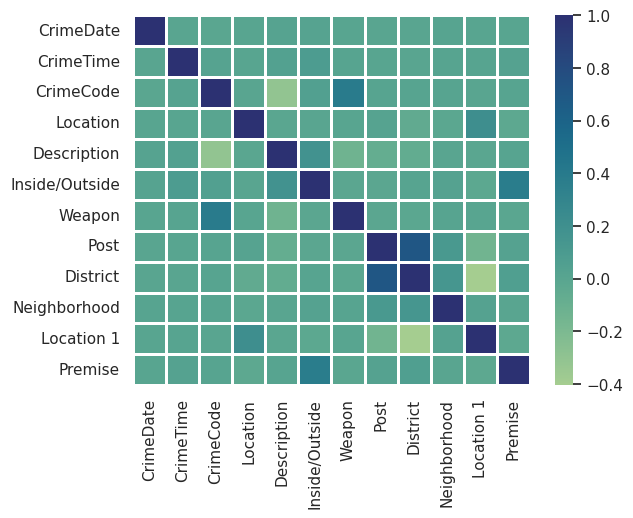

In [42]:

sns.heatmap(df.corr() , lw = 1 , cmap="crest")

It seems like there is no strong correlation between the attributes

### Outliers Detection

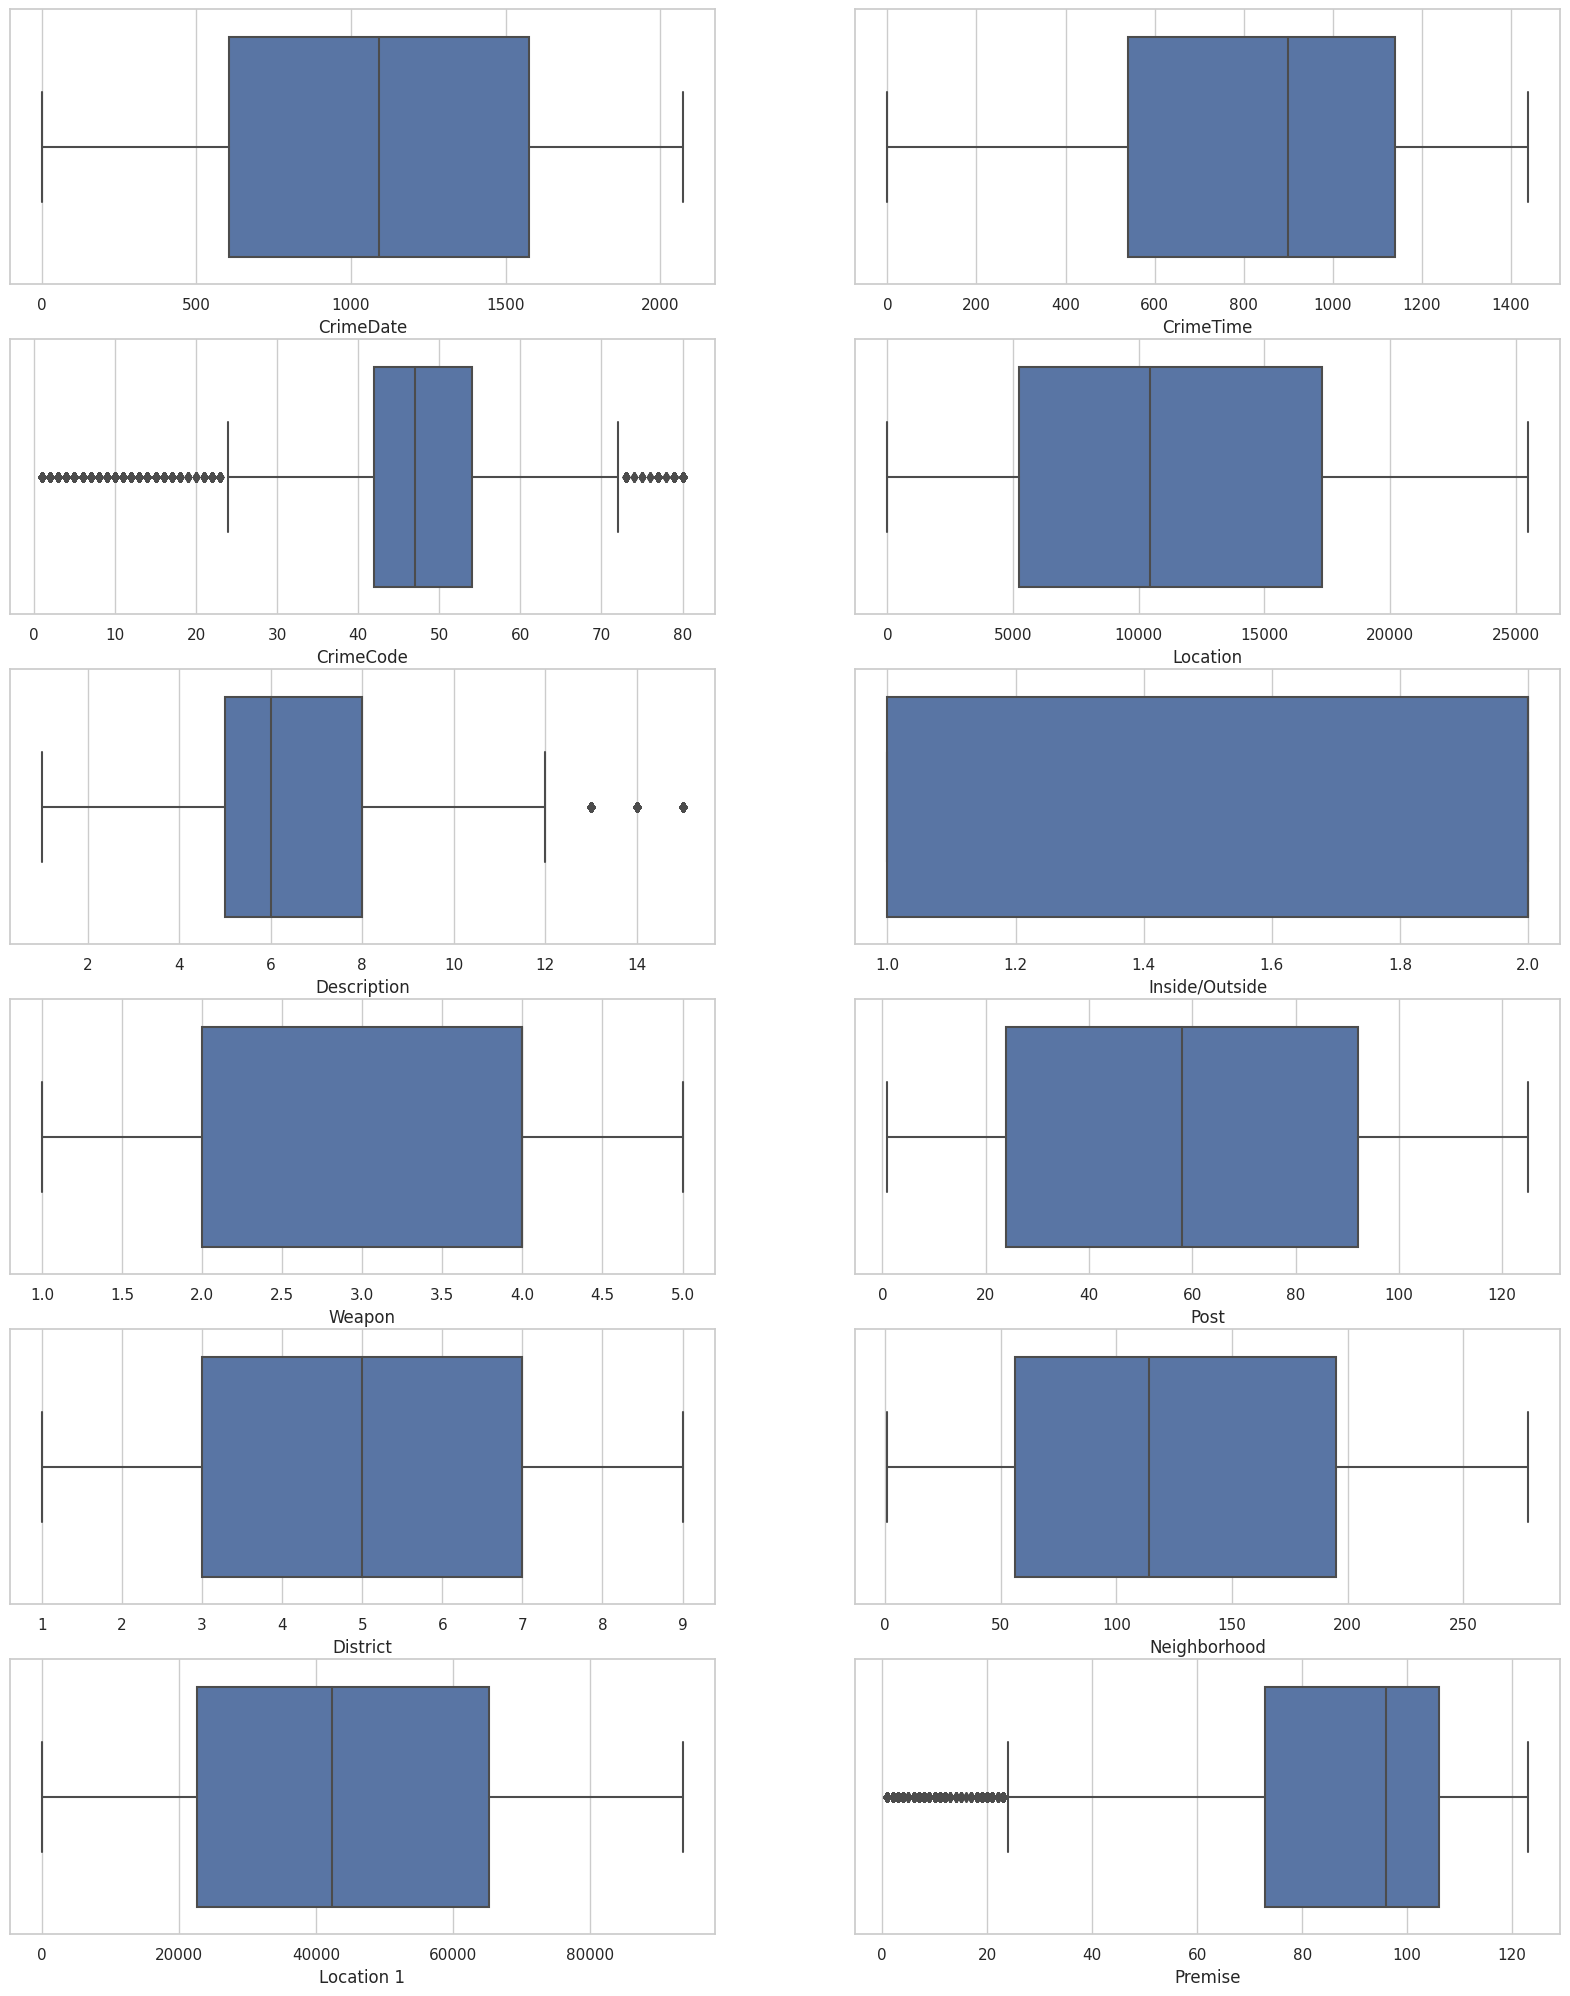

In [43]:
fig, ax = plt.subplots(6 , 2 , figsize=(20, 25))

# flattening the 2D axis into 1D

ax = ax.ravel()

sns.set_theme(style="whitegrid")
for axid, col in enumerate(feature_list):
    sns.boxplot(x=df[col], ax=ax[axid])

we can see there are certain out liers in crime code , premise and description

### Inter Quantile Range

In [44]:
quantile_remove_list = ['Premise' , 'Description' , 'CrimeCode']

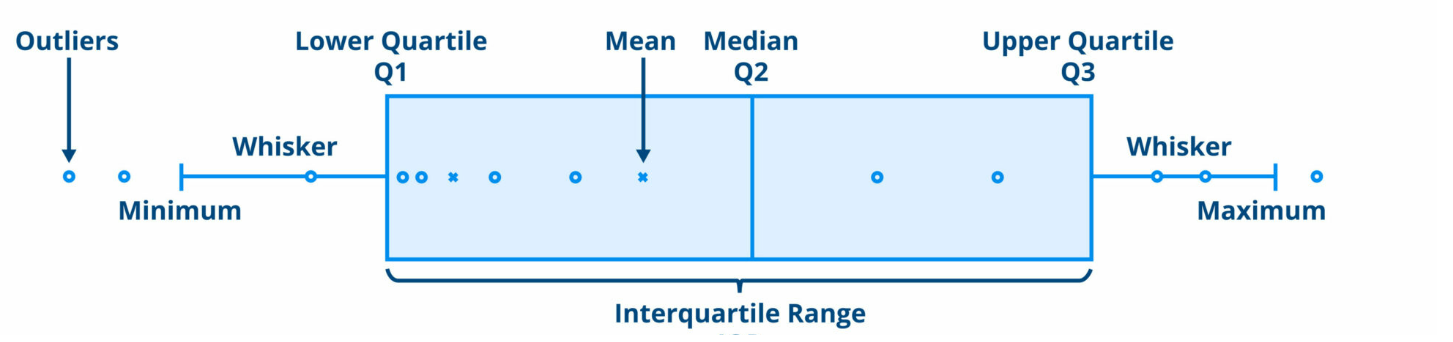

In [45]:
for ind , col in enumerate(quantile_remove_list):
  Q1 = np.percentile(df[col], 25, method='midpoint')
  Q3 = np.percentile(df[col], 75, method='midpoint')
  IRQ = Q3 - Q1
  # upper range is always Q3 + 1.5*IRQ
  # lower range is always Q1 - 1.5*IRQ
  upper_range = Q3 + 1.5*IRQ
  lower_range = Q1 - 1.5*IRQ
  df = df[df[col] >= lower_range]
  df = df[df[col] <= upper_range]

In [46]:
df.shape

(215392, 12)

we are finally left with 215392 instances and 12 columns

# Modeling

### What are we going to predict ?




Based on the following attributes we are going to predict time at which it is not safe to go out in that locality.


*   Crime Description
*   Weapon type
*   Crime category(inside/outside)
*   Crime district



### Model type


* We are going to use ridge regression as regression technique.
* Ridge regression works by adding a penalty term to the cost function, the penalty term being proportional to the sum of the squares of the coefficients. The penalty term is called the L2 norm.


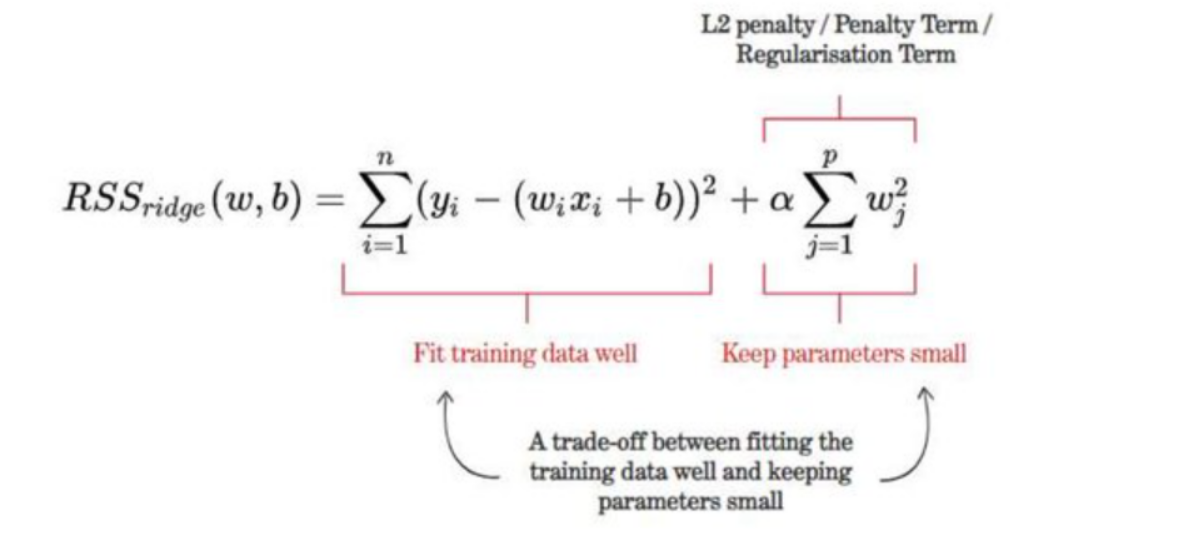
source : vitalflux.com


In [23]:
newdata = df[["Description" , "District" , "Inside/Outside" , "Weapon"]]

In [24]:
newdata.head()

,Description,District,Inside/Outside,Weapon
1,4,1,2,4
3,1,7,1,5
4,6,1,2,2
5,5,7,1,4
8,1,5,2,5


In [61]:
from sklearn.model_selection import train_test_split,GridSearchCV

In [62]:
X_train, X_test, y_train, y_test = train_test_split(newdata, df["CrimeTime"], random_state=42, test_size=0.20)

In [63]:
print(X_train)
print(X_test)
print(y_train)
print(y_test)

        Description  District  Inside/Outside  Weapon
199182            8         3               1       4
128307            5         6               2       4
143498            8         5               1       4
182993            1         2               2       5
242373            8         2               2       4
...             ...       ...             ...     ...
148197            6         6               1       2
128713            4         9               2       4
162481            6         8               1       2
180386            8         5               1       4
150708            9         3               2       4

[172313 rows x 4 columns]
        Description  District  Inside/Outside  Weapon
19427             5         3               1       4
78216             4         5               2       4
84352             9         7               2       4
65947             8         7               1       4
77686             8         2               1       4
.

In [64]:
from sklearn.preprocessing import StandardScaler

In [65]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((172313, 4), (43079, 4))

In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [66]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge=Ridge()
parameters={'alpha':[0 , 0.5 , 1 , 2 , 3]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=5)
ridge_regressor.fit(X_train_scaled, list(y_train))

best_model = ridge_regressor.best_estimator_

y_train_predicted = best_model.predict(X_train_scaled)
train_rmse = np.sqrt(mean_squared_error(list(y_train), y_train_predicted))
train_mae = mean_absolute_error(list(y_train), y_train_predicted)

print("Training root mean sqaure error is " , train_rmse )
print("Training mean absolute error is " , train_mae )
print("Best parameters are " , ridge_regressor.best_params_)

y_predicted = best_model.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(list(y_test), y_predicted))
test_mae = mean_absolute_error(list(y_test), y_predicted)

print("Test root mean sqaure error is " , test_rmse )
print("Test mean absolute error is " , test_mae )

Training root mean sqaure error is  395.5302846741645
Training mean absolute error is  328.3216921596792
Best parameters are  {'alpha': 3}
Test root mean sqaure error is  394.6265930944643
Test mean absolute error is  326.8722482304206


# Inference

### Is it correct to use labelencoder?


Since ervey columns of dataframe is categorical, using labelencoder may leads to the generation of priority issues during model training of data sets encoder from 0 to n-1 may give priority to categorties encoded with higher encoded index.

To overcome this issue we will be using onehotencoding in place of label encoding. Increasing number of features might leads to overfitting thats why are using ridge regression which introduces regularisation.

In [68]:
from sklearn.preprocessing import OneHotEncoder


In [47]:
onehotdf.head()

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Location 1,Premise
0,09/02/2017,1410,3JK,4200 AUDREY AVE,ROBBERY - RESIDENCE,I,KNIFE,913.0,SOUTHERN,Brooklyn,"(39.2295100000, -76.6054100000)",ROW/TOWNHO
1,09/02/2017,1380,7A,800 NEWINGTON AVE,AUTO THEFT,O,NO WEAPON,133.0,CENTRAL,Reservoir Hill,"(39.3136000000, -76.6321700000)",STREET
2,09/02/2017,1373,9S,600 RADNOR AV,SHOOTING,O,FIREARM,524.0,NORTHERN,Winston-Govans,"(39.3476800000, -76.6069700000)",Street
3,09/02/2017,1370,4C,1800 RAMSAY ST,AGG. ASSAULT,I,OTHER,934.0,SOUTHERN,Carrollton Ridge,"(39.2831500000, -76.6452600000)",ROW/TOWNHO
4,09/02/2017,1351,4E,100 LIGHT ST,COMMON ASSAULT,O,HANDS,113.0,CENTRAL,Downtown West,"(39.2875600000, -76.6136500000)",STREET


In [85]:
encoder = OneHotEncoder()

newframe = pd.DataFrame(encoder.fit_transform(onehotdf[['Description', 'Inside/Outside' , 'Weapon' , 'District']]).toarray())

In [86]:
newframe.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
from sklearn.model_selection import train_test_split,GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(newframe, onehotdf["CrimeTime"], random_state=42, test_size=0.20)
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((210494, 31), (52624, 31))

In [88]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge=Ridge()
parameters={'alpha':[0 , 0.5 , 1 , 2 , 3]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=5)
ridge_regressor.fit(X_train_scaled, list(y_train))

best_model = ridge_regressor.best_estimator_

y_train_predicted = best_model.predict(X_train_scaled)
train_rmse = np.sqrt(mean_squared_error(list(y_train), y_train_predicted))
train_mae = mean_absolute_error(list(y_train), y_train_predicted)

print("Training root mean sqaure error is " , train_rmse )
print("Training mean absolute error is " , train_mae )
print("Best parameters are " , ridge_regressor.best_params_)

y_predicted = best_model.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(list(y_test), y_predicted))
test_mae = mean_absolute_error(list(y_test), y_predicted)

print("Test root mean sqaure error is " , test_rmse )
print("Test mean absolute error is " , test_mae )

Training root mean sqaure error is  403.5846972917367
Training mean absolute error is  336.28285238885326
Best parameters are  {'alpha': 3}
Test root mean sqaure error is  402.5102443008169
Test mean absolute error is  334.9937486437779


## conclusion

we can see that training errors and testing errors are almost in same range that suggests our model did not overfit on the data.